<a href="https://colab.research.google.com/github/fmanid/channa-classification-using-M5stickV/blob/master/Channa_Classification_Using_MobileNet_75_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build  model

Install library scipy


In [ ]:
# See https://github.com/raghakot/keras-vis/issues/182
!pip install -I scipy==1.2.*

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached scipy-1.2.3.tar.gz (23.3 MB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for scipy
  Running setup.py clean for scipy
  error: subprocess-exited-with-error
  
  × python setup.py clean did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed cleaning build dir for scipy
Failed to build scipy
ERROR: Could not build wheels for scipy, which is required to install pyproject.toml-based projects


In [ ]:
# Clone the repositopry to get the MobileNet V1 model by DmitryM8
!git clone https://github.com/AIWintermuteAI/transfer_learning_sipeed.git

fatal: destination path 'transfer_learning_sipeed' already exists and is not an empty directory.


In [ ]:
import keras
import numpy as np
from keras import backend as K
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from keras.layers import Dense, GlobalAveragePooling2D, Dropout,Flatten
from keras.applications.mobilenet import preprocess_input
import sys
sys.path.append('/content/transfer_learning_sipeed')
from mobilenet_sipeed.mobilenet import MobileNet

## Download dataset

In [ ]:
#@title Dataset URL

dataset_url = 'https://www.dropbox.com/s/i5gmdk5sl6fx3h2/updated%20rembg.zip?dl=1' #@param {type:"string"}

In [ ]:
dataset_root_dir = '/content/datasets'
dataset_tmp_filename = 'dataset.zip'

import os

# Make the directory for datasets if needed
if not os.path.isdir(dataset_root_dir):
  os.mkdir(dataset_root_dir)

# Download the dataset file from the URL as dataset.zip
get_ipython().system_raw('wget -O {} {}'.format(dataset_tmp_filename, dataset_url))

In [ ]:
import zipfile

dataset_name = ''

with zipfile.ZipFile(dataset_tmp_filename) as zipfile:
    # Get the name of the root directory as the name of the dataset
    dataset_name = os.path.dirname(zipfile.namelist()[0]).split(os.sep)[0]
    zipfile.extractall(dataset_root_dir)

dataset_name

'updated rembg'

In [ ]:
# Delete the dataset file
if os.path.isfile(dataset_tmp_filename):
  os.remove(dataset_tmp_filename)

## Prepare the dataset for learning

In [ ]:
IMAGE_SIZE = 224
ALPHA = 0.75
BATCH_SIZE = 32
EPOCHS = 75

In [ ]:
def prepare_image(file):
    img_path = ''
    img = image.load_img(img_path + file, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

In [ ]:
dataset_dir = os.path.join(dataset_root_dir, dataset_name)

# Uncomment parameters to enable data augmentation
train_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                    # rotation_range=10,
                                    # width_shift_range=0.2,
                                    # height_shift_range=0.2,
                                    # shear_range=0.2,
                                    # zoom_range=0.3,
                                    # horizontal_flip=True,
                                    validation_split=0.1)

train_data = train_data_gen.flow_from_directory(dataset_dir,
                                                subset='training',
                                                target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                color_mode='rgb',
                                                batch_size=BATCH_SIZE,
                                                class_mode='categorical',
                                                shuffle=True)

validation_data = train_data_gen.flow_from_directory(dataset_dir,
                                                     subset='validation',
                                                     target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                     color_mode='rgb',
                                                     batch_size=BATCH_SIZE,
                                                     class_mode='categorical',
                                                     shuffle=True)

Found 720 images belonging to 8 classes.
Found 80 images belonging to 8 classes.


In [ ]:
train_data.class_indices.items()

dict_items([('andrao', 0), ('asiatica', 1), ('auranti', 2), ('limbata', 3), ('maru', 4), ('pulchra', 5), ('red', 6), ('stewarti', 7)])

In [ ]:
# Write labels as labels.txt
with open('labels.txt', 'wt') as f:
    for key, value in train_data.class_indices.items():
        f.write(key + '\n')

## Transfer learning using MobileNet V1

In [ ]:
# Using MobileNet V1
# See https://keras.io/applications/#mobilenet for details
base_model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                       alpha=ALPHA,
                       include_top=False,
                       backend=keras.backend,
                       layers=keras.layers,
                       models=keras.models,
                       utils=keras.utils)

In [ ]:
# Make all layers non-trainable
for layer in base_model.layers:
    layer.trainable = False

# Add layers for transfer learning
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(100, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(train_data.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_pad (ZeroPadding2D)   (None, 226, 226, 3)       0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 24)      648       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 24)     96        
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 24)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 24)     216       
                                                             

## Train the model
Disini dilakukan training data sebanyak 50 kali


In [ ]:
model.compile(optimizer=Adam(lr=0.0001), loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = max(validation_data.n // validation_data.batch_size, 1)

history = model.fit_generator(train_data,
                              steps_per_epoch=steps_per_epoch,
                              epochs=EPOCHS,
                              validation_data=validation_data,
                              validation_steps=validation_steps)

model.save('/content/model.h5')

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
<ipython-input-15-9932666df77a>:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_data,


Epoch 1/75
22/22 [==============================] - 196s 9s/step - loss: 2.3511 - accuracy: 0.1483 - val_loss: 2.0759 - val_accuracy: 0.2188
Epoch 2/75
22/22 [==============================] - 184s 8s/step - loss: 2.0792 - accuracy: 0.1817 - val_loss: 1.9761 - val_accuracy: 0.2656
Epoch 3/75
22/22 [==============================] - 188s 9s/step - loss: 1.9807 - accuracy: 0.2442 - val_loss: 1.9095 - val_accuracy: 0.3125
Epoch 4/75
22/22 [==============================] - 194s 9s/step - loss: 1.8942 - accuracy: 0.2689 - val_loss: 1.8564 - val_accuracy: 0.3594
Epoch 5/75
22/22 [==============================] - 180s 8s/step - loss: 1.8236 - accuracy: 0.2980 - val_loss: 1.7365 - val_accuracy: 0.4062
Epoch 6/75
22/22 [==============================] - 174s 8s/step - loss: 1.7417 - accuracy: 0.3488 - val_loss: 1.6511 - val_accuracy: 0.4688
Epoch 7/75
22/22 [==============================] - 193s 9s/step - loss: 1.6679 - accuracy: 0.3924 - val_loss: 1.5503 - val_accuracy: 0.4844
Epoch 8/75
22



Penyajian dalam bentuk grafik dalam proses training, ditampilkan tingkat akurasi dan loss pada setiap test data dan validation data

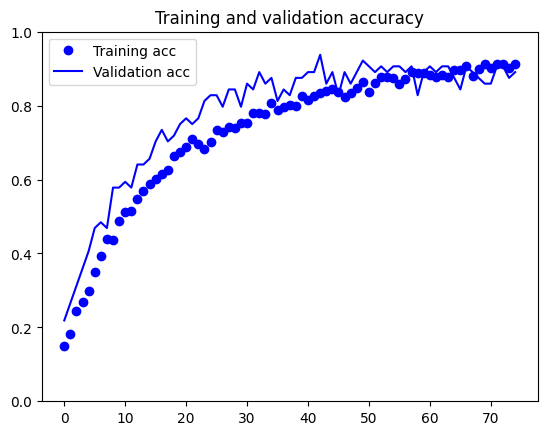

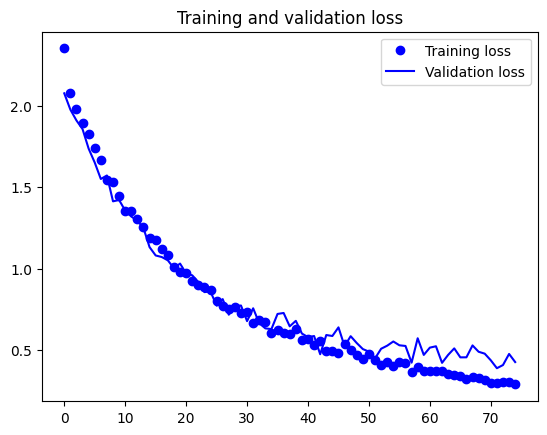

In [ ]:
# https://nbviewer.jupyter.org/github/fchollet/deep-learning-with-python-notebooks/blob/master/5.2-using-convnets-with-small-datasets.ipynb#5.2---Using-convnets-with-small-datasets
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure()
plt.ylim(0, 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Execute inference on the first batch of the validation data and display the classification result.

1/1 [==============================] - 4s 4s/step


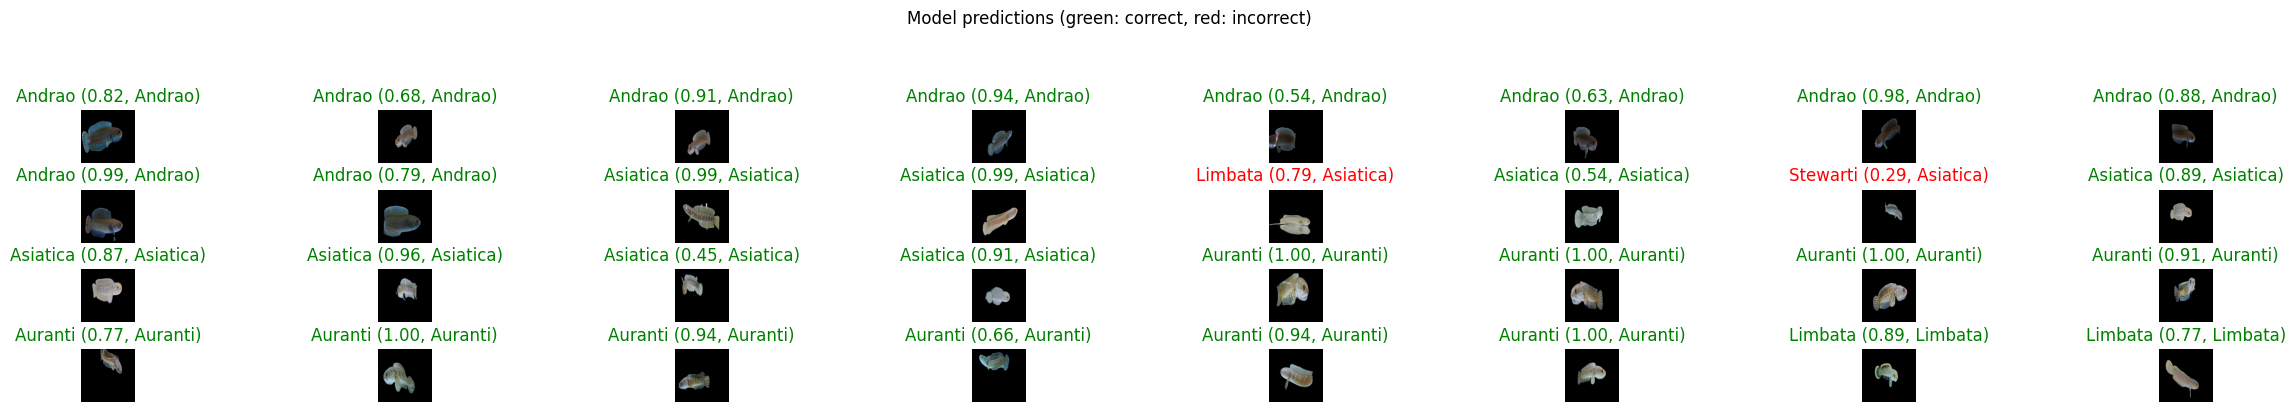

In [ ]:
# Get the ordered list of class names:
import PIL.Image as Image
class_names = validation_data.class_indices.items()
class_names = np.array([key.title() for key, value in class_names])

validation_data.reset()
validation_data.shuffle = False
validation_data.batch_size = BATCH_SIZE

# Retrieve the first batch from the validation data
for validation_image_batch, validation_label_batch in validation_data:
  break

validation_id = np.argmax(validation_label_batch, axis=-1)
validation_label = class_names[validation_id]
predicted_batch = model.predict(validation_image_batch)

# Returns the indices of the maximum values along a given axis
predicted_id = np.argmax(predicted_batch, axis=-1)

# Return the maximum values along a given axis
predicted_score = np.max(predicted_batch, axis=-1)

predicted_label_batch = class_names[predicted_id]

plt.figure(figsize=(30, 10))
plt.subplots_adjust(hspace=0.5)

# Display the classification results for the first 30 images
for n in range(min(validation_image_batch.shape[0], 80)):
  plt.subplot(10, 8, n + 1)

  # Convert the range from -1 to 1 to the range from 0 to 1
  plt.imshow((validation_image_batch[n] + 1) / 2)
  color = 'green' if predicted_id[n] == validation_id[n] else 'red'
  predicted_label = predicted_label_batch[n].title()
  plt.title(predicted_label + ' ({:.2f}, {})'.format(
      predicted_score[n], validation_label[n]), color=color)
  plt.axis('off')

_ = plt.suptitle('Model predictions (green: correct, red: incorrect)')

<ipython-input-28-a8412f4b1e62>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predicted = model.predict_generator(validation_data, steps=validation_data.n)


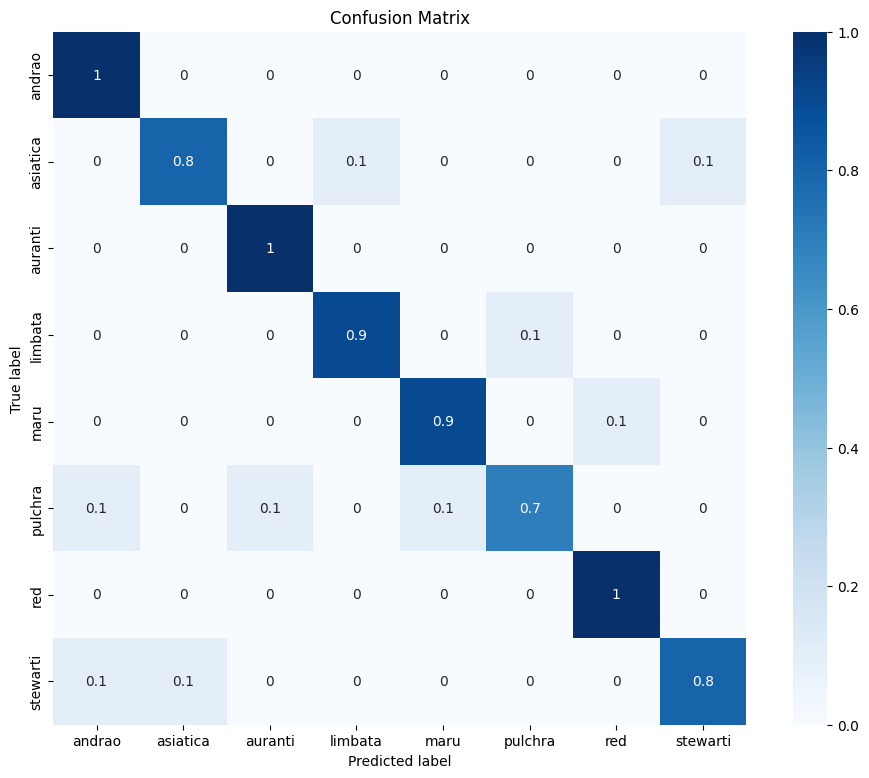

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

validation_data.reset()
validation_data.shuffle = False
validation_data.batch_size = 1

predicted = model.predict_generator(validation_data, steps=validation_data.n)
predicted_classes = np.argmax(predicted, axis=-1)

# Apply normalization
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
cm = confusion_matrix(validation_data.classes, predicted_classes)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 9))

# https://seaborn.pydata.org/generated/seaborn.heatmap.html
# https://matplotlib.org/users/colormaps.html
sns.heatmap(cm, annot=True, square=True, cmap=plt.cm.Blues,
            xticklabels=validation_data.class_indices,
            yticklabels=validation_data.class_indices)

plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Convert the model

ツール（[Maix Toolbox](https://github.com/sipeed/Maix_Toolbox)および[nncase](https://github.com/kendryte/nncase/)）をインストールして、tflite（TensorFlow Lite）を介してモデルをh5（Keras）からkmodel（K210）に変換します。

Install the tools ([Maix Toolbox](https://github.com/sipeed/Maix_Toolbox) and [nncase](https://github.com/kendryte/nncase/)) to convert your model from h5 (Keras) to kmodel (K210) via tflite (TensorFlow Lite).

## Install Maix Toolbox and nncase

Note that there is a bug in the get_nncase.sh in the Maix_Toolbox which is unable to extract the file. The steps below is the same as the script but the typo error is fixed.

In [ ]:
!git clone https://github.com/sipeed/Maix_Toolbox.git

Cloning into 'Maix_Toolbox'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 34 (delta 6), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (34/34), 13.45 KiB | 1.34 MiB/s, done.


In [ ]:
%%bash
cd Maix_Toolbox 
mkdir -p ncc
mkdir -p workspace
mkdir -p images
mkdir -p log
cd ncc
wget https://github.com/kendryte/nncase/releases/download/v0.1.0-rc5/ncc-linux-x86_64.tar.xz
tar -Jxf ncc-linux-x86_64.tar.xz
rm ncc-linux-x86_64.tar.xz
echo "download nncase ok!"

## Convert from h5 to tflite

In [ ]:
#convert keras to tflite format
!tflite_convert  --output_file=/content/model.tflite --keras_model_file=/content/model.h5

## Convert from tflite to kmodel

nncaseを用いてtflite形式からK210用の形式に変換する際、学習時に用いたデータが必要になります（[README.md](https://github.com/kendryte/nncase/blob/master/README.md)の`--dataset`オプションに関する説明を参照）。この際、元のデータセットをそのまま与えてしまうと変換に非常に長い時間がかかってしまいます。これを避けるため、バリデーションで用いたデータの中からカテゴリごとに最初の10枚だけをコピーし、nncに与えます。

When nncase is used to convert from the tflite format to the K 210 format, the data used at the time of learning is required (see the description of the `--dataset` in [README.md](https://github.com/kendryte/nncase/blob/master/README.md)). If the original data set is supplied as it is, the conversion takes a very long time. To avoid this, copy the first ten images of data used as the validation data for each category and supply to nnc.

In [ ]:
import shutil

test_dataset_dir = '/content/test'

if not os.path.isdir(test_dataset_dir):
  os.mkdir(test_dataset_dir)

for key, value in validation_data.class_indices.items():
  src_dir = os.path.join(dataset_root_dir, dataset_name, key)
  dest_dir = os.path.join(test_dataset_dir, key)

  if not os.path.isdir(dest_dir):
    os.mkdir(dest_dir)

  count = 0
  for item in os.listdir(src_dir):
    file_path = os.path.join(src_dir, item)

    if os.path.isfile(file_path):
      shutil.copy(file_path, dest_dir)

    count += 1

    if count == 10:
      break

In [ ]:
%cd /content/Maix_Toolbox
!./ncc/ncc -i tflite -o k210model --dataset /content/test /content/model.tflite /content/model.kmodel

## Download the generated files

これでモデルの変換は完了し、M5StickV（K210）で使う準備ができました。次のセルを実行すると、モデル（model.kmodel）、ラベル（labels.txt）、および起動スクリプト（boot.py）の合計3つのファイルをZIPファイルにまとめてダウンロードされます。これらすべてをmicroSDカードの上部にコピーし、M5StickVに挿入してオンにすると、学習したモデルで画像識別ができるはずです。

Now, your model is converted and ready for M5StickV (K210). By executing the following cells, you can download a ZIP file that contains three files: the model (model.kmodel), the label (labels.txt), and the startup script (boot.py). If you copy all of this to the top of your microSD card, insert it into your M5StickV, and turn it on, you should be able to do image classification with the learned model.

In [ ]:
# Get the script to be used on a M5StickV
%cd /content
!git clone https://gist.github.com/65b06e10be209607bf9ca63748564ee9.git

In [ ]:
from datetime import datetime
from pytz import timezone
import zipfile

now = datetime.now(timezone('UTC'))
now = now.astimezone(timezone('Asia/Tokyo'))
zipped_model_path = '/content/model_{0:%Y-%m-%d_%H-%M-%S}.zip'.format(now)

with zipfile.ZipFile(zipped_model_path, 'w', compression=zipfile.ZIP_DEFLATED) as zipped_model:
  zipped_model.write('/content/model.tflite', arcname='model.tflite')
  zipped_model.write('/content/model.h5', arcname='model.h5')
  zipped_model.write('/content/model.kmodel', arcname='model.kmodel')
  zipped_model.write('/content/labels.txt', arcname='labels.txt')
  zipped_model.write('/content/65b06e10be209607bf9ca63748564ee9/boot.py', arcname='boot.py')

In [ ]:
from google.colab import files

files.download(zipped_model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>